# Bayesian Regularization Notebook

Maia Tienstra <br>
Master Thesis project <br>
Date: 21-01-2022

In [1]:
from bayes_reg import*
import os


In [2]:
#run if made changes to py file

import importlib

import bayes_reg 
importlib.reload(bayes_reg)
from bayes_reg import*

In [3]:
plot_path = os.getcwd()+'/Plots/'
csv_path = os.getcwd()+'/CSV/'

## Data

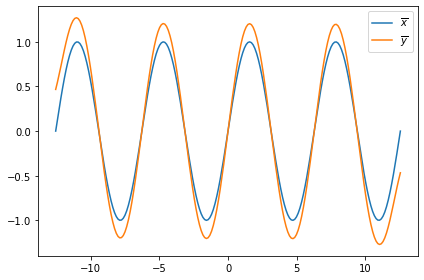

In [4]:
'''
Example Sinoid Function
'''

# parameters
n = 200
sigma = 1e-2


#t has numbers ranging from 1/400 to 1-1/400 and is of len 200
t = np.linspace(-4*np.pi, 4*np.pi, n)

# operators
A = getA(t)
L = getL(t)


# Make some data
x_bar = np.sin(t)
y_bar = A@x_bar

plt.plot(t,x_bar,label=r'$\overline{x}$')
plt.plot(t,y_bar,label=r'$\overline{y}$')
plt.legend()
plt.tight_layout()
plt.savefig(plot_path+'example.jpeg',dpi=500)
plt.show()


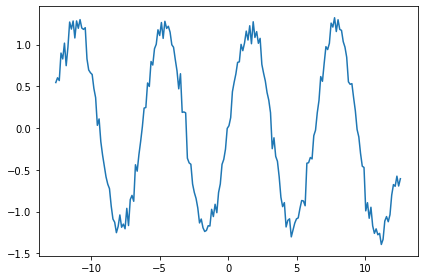

In [5]:
sigma   = 1e-1
y_delta = y_bar + sigma*np.random.randn(n)
plt.plot(t,y_delta)
plt.tight_layout()
plt.savefig(plot_path+'noisy_observations.jpeg',dpi=500)
plt.show()

### Randomly spaced points

In [6]:
# xmin, xmax, num = -4*np.pi, 4*np.pi, 200
# func = lambda x: np.sin(x) 

# # Generate evenly spaced data...
# x_even = np.linspace(xmin, xmax, num)

# # Generate randomly spaced data...
# x = np.random.random(num)
# x_rand = (xmax - xmin) * x + xmin
# x_rand = sorted(x_rand)

# # Plot the results
# fig, axes = plt.subplots(nrows=2, sharex=True)
# for x, ax in zip([x_even, x_rand], axes):
#     ax.plot(x, func(x), marker='o', mfc='red')
# axes[0].set_title('Evenly Spaced Points')
# axes[1].set_title('Randomly Spaced Points')


In [7]:
# # operators
# A = getA(x_rand)
# L = getL(x_rand)


# # Make some data
# x_bar = np.sin(x_rand)
# y_bar = A@x_bar

# plt.plot(x_rand,x_bar,label=r'$\overline{x}$')
# plt.plot(x_rand,y_bar,label=r'$\overline{y}$')
# plt.legend()
# plt.show()

In [8]:
# sigma   = 1e-1
# y_delta = y_bar + sigma*np.random.randn(n)
# plt.plot(t,y_delta)
# plt.show()

## Ill-posedness

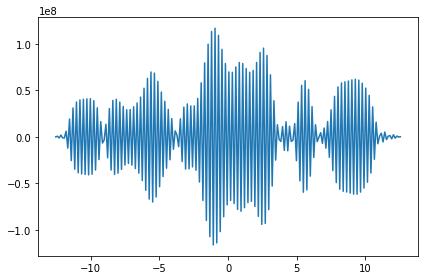

In [9]:
plt.plot(t,np.linalg.inv(A)@(y_bar-sigma*np.random.randn(n)))
plt.tight_layout()
plt.savefig(plot_path+'least_sqrs_estimate.jpeg',dpi=500)
plt.show()

### Condition number and rank of A

In [10]:
U,S,Vh = np.linalg.svd(A)

In [11]:
np.linalg.matrix_rank(A)

200

In [12]:
kappa = np.linalg.cond(A)

In [13]:
np.log10(kappa)

9.68912935204352

In [14]:
10**9.689

4886523593.428336

In [15]:
sigma_min = np.min(S)
sigma_max = np.max(S)
kappa = sigma_max/sigma_min
print('s_max:', sigma_max)
print('s_min:', sigma_min)
print('Condition number: 1 << ',kappa)

s_max: 1.9676012686895668
s_min: 4.0253879469578856e-10
Condition number: 1 <<  4887979232.353358


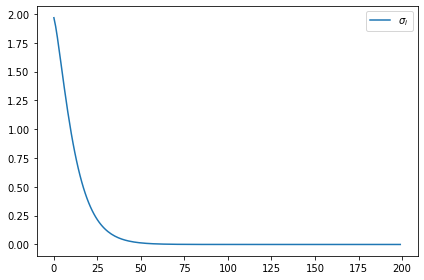

In [16]:
plt.plot(list(range(0,200)),S, label='$\sigma_i$')
plt.legend()
plt.tight_layout()
plt.savefig(plot_path+'eigen_values.jpeg',dpi=500)
plt.show()

In [17]:
x_ls = Vh.T@np.diag(1/S)@U.T@y_delta

In [18]:
np.linalg.norm(x_ls - x_bar)**2

6.469924531831558e+17

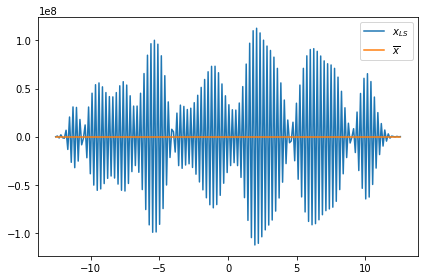

In [19]:
plt.plot(t,x_ls, label='$x_{LS}$')
plt.plot(t,x_bar, label='$\overline{x}$')
plt.legend()
plt.tight_layout()
plt.show()

### Picard Condition

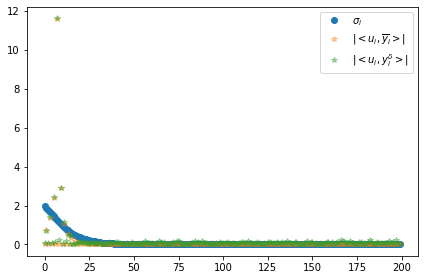

In [20]:
plt.plot(list(range(0,200)),S, 'o', label='$\sigma_i$')
plt.plot(list(range(0,200)),np.abs(U.T@y_bar),'*',alpha=0.4,label='$|<u_i, \overline{y}_i>|$')
plt.plot(list(range(0,200)), np.abs(U.T@y_delta), '*',alpha=0.4, label='$|<u_i, y^\delta_i>|$')
plt.legend()
plt.tight_layout()
plt.savefig(plot_path+'picard.jpeg',dpi=500)
plt.show()

## Regularization

### With Hyperpriors

We now add the following hyper priors on the variances

\begin{align}
    \alpha  &\sim Gamma(a_0,b_0)\\
    \beta  &\sim Gamma(a_1,b_1)
\end{align}


Then the posterior becomes 
\begin{align}
    p(x,\alpha, \beta \mid y) &\propto \rho(Ax-y \mid \alpha ) \times \pi(\alpha) \pi(x \mid \beta) \times \pi(\beta)\\
    & \propto \alpha^{n/2}e^{-\alpha/2 ||Ax-y||^2}\alpha^{a_0 -1}e^{-b_0 \alpha}\beta^{n/2}e^{-\beta/2||Lx||^2}\beta^{a_1 -1}e^{-b_1\beta}
\end{align}

taking the log we get
\begin{align}
    -\alpha/2||Ax-y||^2 + (n/2+a_0-1) log(\alpha)-b_0\alpha -\beta/2||Lx||^2 + (n/2+a_1-1)log(\beta)-b_1\beta
\end{align}

then the potential is 

\begin{align}
    \ell(x, \alpha, \beta \mid y) = \alpha/2||Ax-y||^2 - (n/2+a_0-1) log(\alpha)+b_0\alpha + \beta/2||Lx||^2 - (n/2+a_1-1)log(\beta)+b_1\beta
\end{align}


If we minimize the above regularized least squares over $x, \alpha, \beta$ we see that we have Tikhonov regularization with regularization parameter $\lambda = \beta/\alpha$. 

Now recall that the likelihood and priors are conjugate we have that the posterior distribution is Gaussian. This posterior distribution is maximized when the $\ell(x, \alpha, \beta \mid y)$ is minimized. So we define the following

\begin{align}
    \mathcal{J}(x,\alpha,\beta) =
    \alpha/2||Ax-y||^2 - (n/2+a_0-1)log(\alpha)+b_0\alpha + \beta/2||Lx||^2 - (n/2+a_1-1)log(\beta)+b_1\beta
\end{align}

as the objective function. In this way finding $\widehat{x}, \widehat{\alpha}, \widehat{\beta}$ is an optimization problem, which can be solved using the following. Note that if we let $a_0,a_1=1$ and $b_0,b_1=0$ the we recover the objective function given no hyper priors.

Then the partial derivatives are
\begin{align}
    \partial/\partial x(J(x,\alpha, \beta )) &= (A^*A+\beta/\alpha L^*L)x-A^*y\\
    \partial/\partial \alpha  J(x,\alpha, \beta ) &= 1/2||Ax-y||^2 -(n/2+a_0 -1)/\alpha +b_0\\
    \partial/\partial \beta  J(x,\alpha, \beta ) &= 1/2||Lx||^2 -(n/2+a_1 -1)/\beta +b_1
\end{align}

Then the optimal solutions ie when the partials are zero are 
\begin{align}
    x &= (A^*A + \beta /\alpha L^*L)^{-1}A^*y\\
    \alpha &=\frac{(n/2+a_0 -1)}{ 1/2||Ax-y||^2  + b_0}\\
    \beta &= \frac{(n/2+a_1 -1)} {1/2||Lx||^2  + b_1}
\end{align}

We propose three different iterative methods to ways to minimize $\mathcal{J}(x, \alpha, \beta)$

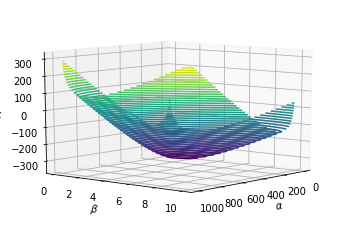

In [21]:
from mpl_toolkits import mplot3d

def f(x, y):
    return getObj(A,L,y_delta, x, y)


x = np.logspace(1,3,n)
y = np.logspace(-1,1,n)


X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='viridis')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('z');

ax.view_init(10,40)

fig.savefig(plot_path+'3d_contour.jpeg',dpi=300)

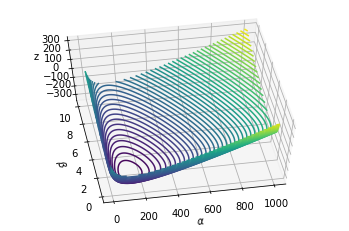

In [22]:
ax.view_init(60, 260)
fig

In [23]:
my_dict = {}
sigma   = 1e-1
y_delta = y_bar + sigma*np.random.randn(n)

### Method 1


Coordinate descent with step size 1. 

$$x_{k+1} = \widehat{x}(\beta_k/\alpha_k),$$

$$\alpha_{k+1} = \widehat{\alpha}(x_{k+1})$$

$$\beta_{k+1} = \widehat{\beta}(x_{k+1})$$

In [24]:
x_hat,alpha_hat,beta_hat,obj, df1 =Algorithm1(A,L,y_delta,niter=100000,tol=1e-8,print_res=True)
err = np.linalg.norm(x_bar-x_hat)**2
my_dict['Algo1']=[alpha_hat,beta_hat, beta_hat/alpha_hat, obj[-1],err,len(obj)-1]

Successful
Iterations: 5
Gradient: 9.19169894761193e-09


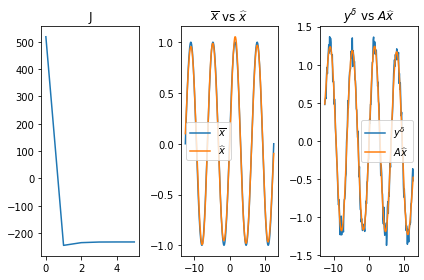

Lambda: 0.018100999743228957
Error: 0.21118625802367375
Obj val: -232.63261255390844


In [25]:
name = plot_path+'algo1'
plot_results(obj, t,A, x_bar, x_hat,alpha_hat, beta_hat, y_delta,name)

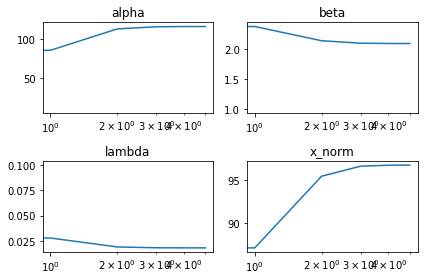

In [26]:
plot_estimates(df1,name)

In [27]:
df1.to_csv(csv_path+'algo_1')

In [28]:
df1

,x_norm,alpha,beta,lambda,obj,$||\nabla_x J||$,$||\nabla_{a} J||$,$||\nabla_{B} J||$
0,91.231325,10.000000,1.000000,0.100000,518.693678,1.824985e+07,4.970687e+01,6.094553e+02
1,87.113342,85.383774,2.378431,0.027856,-245.109513,4.462294e-01,6.767792e-33,6.374399e-30
2,95.406875,112.716063,2.141842,0.019002,-235.176093,9.691578e-03,8.268908e-34,9.274046e-29
3,96.567481,115.491283,2.100506,0.018188,-232.903871,9.973831e-05,8.268908e-34,9.274046e-29
4,96.677655,115.745532,2.096002,0.018109,-232.657017,9.598680e-07,8.268908e-34,6.374399e-30
5,96.688361,115.770201,2.095556,0.018101,-232.632613,9.191699e-09,8.268908e-34,6.374399e-30


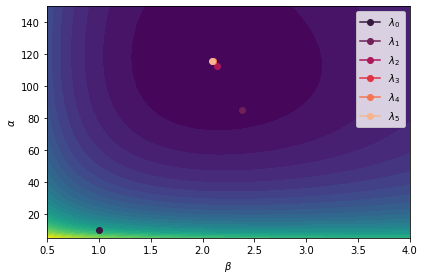

In [29]:
plot_contour(A,L, y_delta, df1, name , ranges=[5,150,0.5,4])

#### Convergence

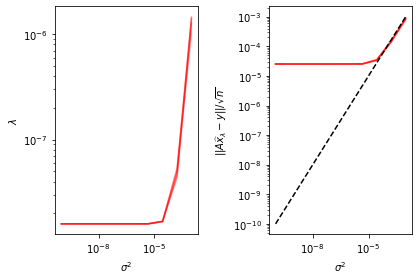

In [30]:
ns = 10
na = 10

sigmas = np.logspace(-10,-3,ns)

lmbds_map = np.zeros((ns,na))
errors    = np.zeros((ns,na))
residuals = np.zeros((ns,na))
for i in range(ns):
    for j in range(na):
        
        y_delta = y_bar + sigmas[i]*np.random.randn(n)
        x_hat, alpha_hat, beta_hat,_,_ = Algorithm1(A,L,y_delta,niter=100000,tol=1e-10)
        lmbda_hat = beta_hat / alpha_hat
        
        lmbds_map[i,j] = lmbda_hat
        errors[i,j] = np.linalg.norm(x_bar-x_hat)
        residuals[i,j] = np.linalg.norm(A@x_hat - y_delta)
        
fig,axs = plt.subplots(1,2)

axs[0].loglog(sigmas,lmbds_map,'r-',alpha=.2)
axs[0].set_xlabel(r'$\sigma^2$')
axs[0].set_ylabel(r'$\lambda$')

axs[1].loglog(sigmas,residuals/np.sqrt(n),'r-',alpha=0.2)
axs[1].loglog(sigmas,sigmas,'k--')
axs[1].set_xlabel(r'$\sigma^2$')
axs[1].set_ylabel(r'$||A\widehat{x}_\lambda - y||/\sqrt{n}$')
plt.tight_layout()
plt.savefig(plot_path+'consis_convg.jpeg',dpi=500)
plt.show()

#### Sensitivity 

In [31]:
y_delta = y_bar + sigma*np.random.randn(n)

Successful
Iterations: 2
Gradient: 0.00045026146895007217


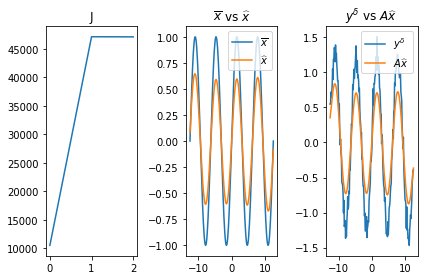

Lambda: 0.999419998194936
Error: 14.557886449237749
Obj val: 47086.8806515838
Successful
Iterations: 5
Gradient: 0.00022673674799912968


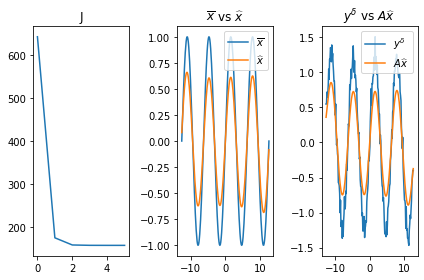

Lambda: 0.9363383086905406
Error: 13.435878123348074
Obj val: 157.33819446334792
Successful
Iterations: 3
Gradient: 0.00011506260804669477


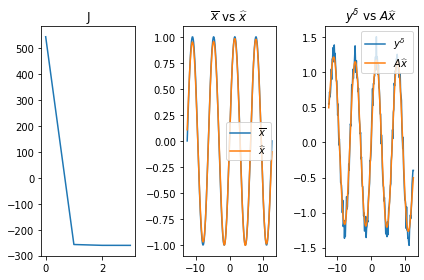

Lambda: 0.04477959095946894
Error: 0.14816613885933835
Obj val: -260.2426940027098
Successful
Iterations: 3
Gradient: 0.00012044505658747519


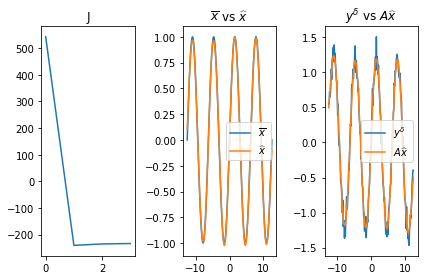

Lambda: 0.022046152595167904
Error: 0.11543637092549902
Obj val: -233.38345448774922
Successful
Iterations: 3
Gradient: 0.00012082439762063936


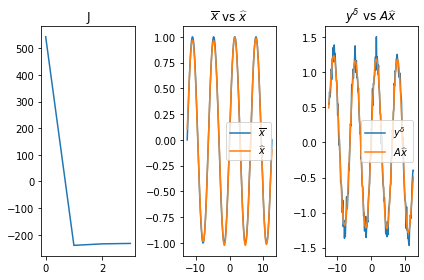

Lambda: 0.02182167788562007
Error: 0.11549643844122391
Obj val: -232.46851645461055
Successful
Iterations: 3
Gradient: 0.00012082829338082487


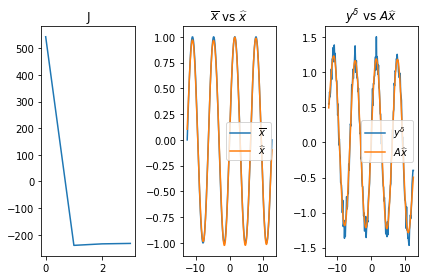

Lambda: 0.021819433322647012
Error: 0.11549709938553031
Obj val: -232.45922668165844
Successful
Iterations: 3
Gradient: 0.00012082833235423038


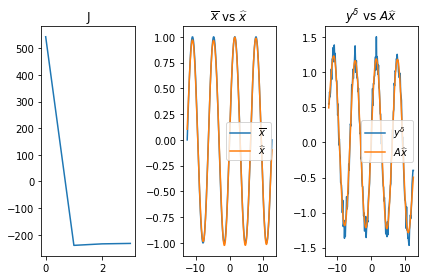

Lambda: 0.021819410877036108
Error: 0.11549710600095499
Obj val: -232.45913376973337


In [32]:
b_s = [1e4, 1e2, 1, 1e-2, 1e-4,1e-6, 1e-8]

sensitivity_dict = {}
for i in b_s:
    hyper_priors = [1+1e-6, i, 1+1e-6, i]
    
    x_hat,alpha_hat,beta_hat,obj, df =Algorithm1(A,L,y_delta,hyper_priors, niter=100000,tol=1e-3,print_res=True)
    
    err = np.linalg.norm(x_bar-x_hat)**2
    
    sensitivity_dict['b_0 : '+str(i)] = [alpha_hat,beta_hat, beta_hat/alpha_hat, obj[-1],
                                               err,len(obj)-1,df]
    name = plot_path+'b_0 : '+str(i)
    plot_results(obj, t,A, x_bar, x_hat,alpha_hat, beta_hat, y_delta,name)
    

In [33]:
sens_df = pd.DataFrame.from_dict(sensitivity_dict, orient='index')
sens_df.columns=['alpha','beta','lambda','obj','$||\overline{x}-\hat{x}||^2_2$','niter','df']
sens_df_prime = sens_df[['alpha','beta','lambda','obj','$||\overline{x}-\hat{x}||^2_2$','niter']]
sens_df_prime.style.set_properties(subset=['$||\overline{x}-\hat{x}||^2_2$'], **{'width': '100px'})

,alpha,beta,lambda,obj,$||\overline{x}-\hat{x}||^2_2$,niter
b_0 : 10000.0,0.009988,0.009982,0.999420,47086.880652,14.557886,2
b_0 : 100.0,0.895728,0.838705,0.936338,157.338194,13.435878,5
b_0 : 1,47.191562,2.113219,0.044780,-260.242694,0.148166,3
b_0 : 0.01,93.971350,2.071707,0.022046,-233.383454,0.115436,3
b_0 : 0.0001,94.906762,2.071025,0.021822,-232.468516,0.115496,3
b_0 : 1e-06,94.916210,2.071018,0.021819,-232.459227,0.115497,3
b_0 : 1e-08,94.916305,2.071018,0.021819,-232.459134,0.115497,3


In [34]:
#print(sens_df[['alpha','beta','lambda','obj','$||\overline{x}-\hat{x}||^2_2$','niter']].to_latex())

Successful
Iterations: 3
Gradient: 0.00012082829338082487


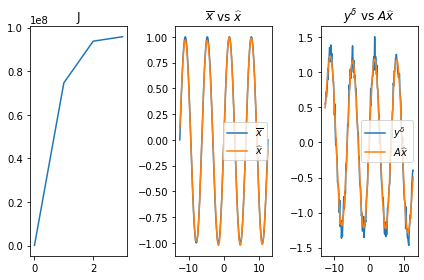

Lambda: 0.021819433322647012
Error: 0.11549709938553031
Obj val: 95802030.8244948
Successful
Iterations: 3
Gradient: 0.00012082829338021815


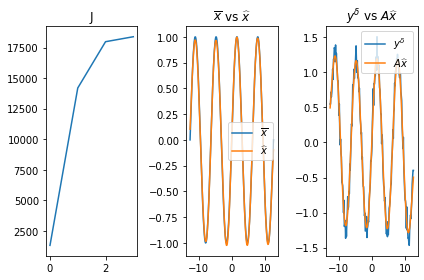

Lambda: 0.02181943332264474
Error: 0.1154970993855129
Obj val: 18383.14816722108
Successful
Iterations: 3
Gradient: 0.00012082829338192558


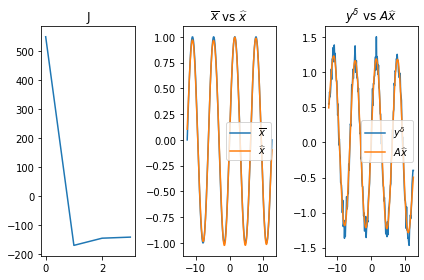

Lambda: 0.021819433322644854
Error: 0.11549709938551604
Obj val: -140.18784630424128
Successful
Iterations: 3
Gradient: 0.00012082829338221199


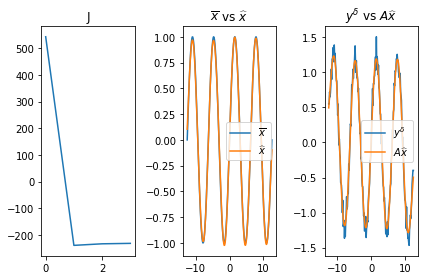

Lambda: 0.021819433322649198
Error: 0.1154970993855686
Obj val: -231.5459993350574
Successful
Iterations: 3
Gradient: 0.00012082829338221199


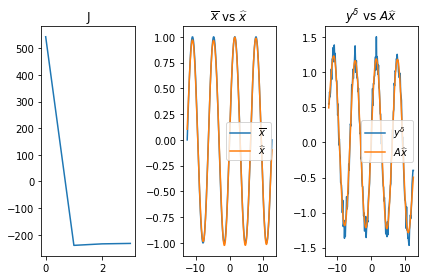

Lambda: 0.021819433322649198
Error: 0.1154970993855686
Obj val: -232.45018575697082
Successful
Iterations: 3
Gradient: 0.00012082829338082487


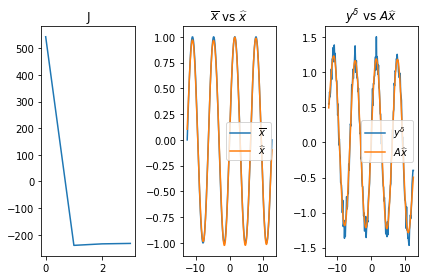

Lambda: 0.021819433322647012
Error: 0.11549709938553031
Obj val: -232.45922668165844
Successful
Iterations: 3
Gradient: 0.00012082829338601514


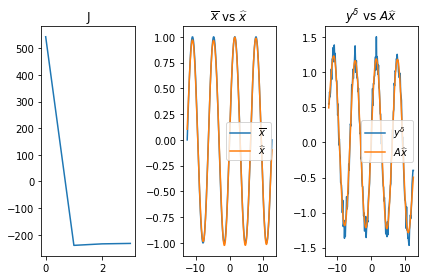

Lambda: 0.02181943332264701
Error: 0.11549709938553031
Obj val: -232.4593170908115


In [35]:
a_s = [1e4, 1e2, 1, 1e-2, 1e-4,1e-6, 1e-8]

sensitivity_dict = {}
for i in a_s:
    hyper_priors = [1+i, 1e-6, 1+i, 1e-6]
    
    x_hat,alpha_hat,beta_hat,obj, df =Algorithm1(A,L,y_delta,hyper_priors, niter=100000,tol=1e-3,print_res=True)
    
    err = np.linalg.norm(x_bar-x_hat)**2
    
    sensitivity_dict['a_0 : 1+'+str(i)] = [alpha_hat,beta_hat, beta_hat/alpha_hat, obj[-1],
                                               err,len(obj)-1,df]
    name = plot_path+'a_0 : '+str(i)
    plot_results(obj, t,A, x_bar, x_hat,alpha_hat, beta_hat, y_delta,name)

In [36]:
sens_df = pd.DataFrame.from_dict(sensitivity_dict, orient='index')
sens_df.columns=['alpha','beta','lambda','obj','$||\overline{x}-\hat{x}||^2_2$','niter','df']
sens_df = sens_df.round(4)
sens_df_prime = sens_df[['alpha','beta','lambda','obj','$||\overline{x}-\hat{x}||^2_2$','niter']]
sens_df_prime.style.set_properties(subset=['$||\overline{x}-\hat{x}||^2_2$'], **{'width': '100px'})

,alpha,beta,lambda,obj,$||\overline{x}-\hat{x}||^2_2$,niter
a_0 : 1+10000.0,9586.537100,209.172800,0.021800,95802030.824500,0.115500,3
a_0 : 1+100.0,189.832400,4.142000,0.021800,18383.148200,0.115500,3
a_0 : 1+1,95.865400,2.091700,0.021800,-140.187800,0.115500,3
a_0 : 1+0.01,94.925700,2.071200,0.021800,-231.546000,0.115500,3
a_0 : 1+0.0001,94.916300,2.071000,0.021800,-232.450200,0.115500,3
a_0 : 1+1e-06,94.916200,2.071000,0.021800,-232.459200,0.115500,3
a_0 : 1+1e-08,94.916200,2.071000,0.021800,-232.459300,0.115500,3


Comment: at some choices of hyperpriors we get concavity? 

### Method 2


Something in between coordinate and gradient descent 

$$\min_{\alpha,\beta} J_2(\alpha,\beta),$$

with 

$$J_2(\alpha,\beta) = \min_x \alpha/2 \|Ax - y\|^2 + \beta/2 \|Lx\|^2 - (n/2+a_0 -1)\log \alpha + b_0 - (n/2+a_1 -1)\log\beta + b_1$$

with a gradient method

$$\alpha_{k+1} = \alpha_k - \mu \partial_{\alpha} J_2(\alpha_k,\beta_k),$$
$$\beta_{k+1} = \beta_k - \mu \partial_{\beta} J_2(\alpha_k,\beta_k),$$


where

$$\partial_{\alpha} J_2 = 1/2\|A\widehat{x}(\beta/\alpha) - y\|^2 - (n/2+a_0 -1)/\alpha +b_0,$$

$$\partial_{\beta} J_2 = 1/2\|L\widehat{x}(\beta/\alpha)\|^2 - (n/2+a_1 -1)/\beta +b_1,$$


In [37]:
sigma   = 1e-1
y_delta = y_bar + sigma*np.random.randn(n)
x_hat,alpha_hat,beta_hat,obj,df2 = Algorithm2(A,L,y_delta,mu_a = 1e-1,mu_b=1e-3, niter=100000,tol=1e-8,print_res=True)

err = np.linalg.norm(x_bar-x_hat)**2

my_dict['Algo2']=[alpha_hat,beta_hat,beta_hat/alpha_hat, obj[-1],err,len(obj)-1]

Successful
Iterations: 8130
Gradient: 9.99947537938507e-09


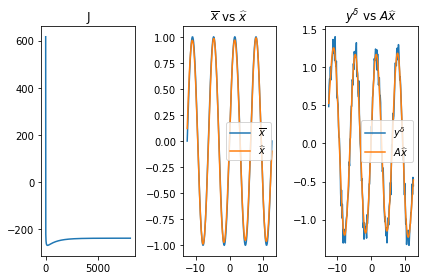

Lambda: 0.022225218763643355
Error: 0.2297852106332735
Obj val: -237.01650880789313


In [38]:
name = plot_path+'algo2'
plot_results(obj, t,A, x_bar, x_hat,alpha_hat, beta_hat, y_delta,name)

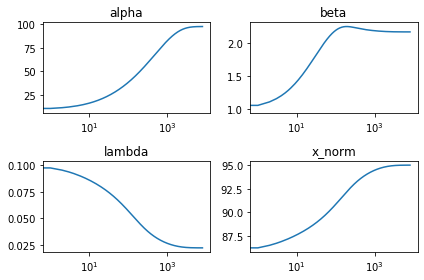

In [39]:
plot_estimates(df2,name)

In [40]:
df2.to_csv(csv_path+'algo_2')

In [41]:
# np.unique(np.logspace(0, 5, 20).astype(np.int))

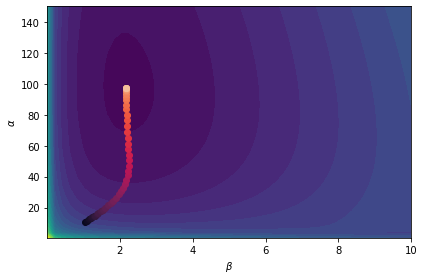

In [42]:
plot_contour(A,L, y_delta, df2, name)

### Method 3

Gradient descent

$$\min_x J_3(x),$$

$$J_3(x) = J(x,\widehat{\alpha}(x),\widehat{\beta}(x)) = \widehat{\alpha}(x)/2||Ax -y||^2 - (n/2+a_0 -1)log( \widehat{\alpha}(x)) -  b_0\widehat{\alpha}(x) + \widehat{\beta}(x)/2||Lx||^2 - (n/2+a_1 -1)log( \widehat{\beta}(x)) + b_1 \widehat{\beta}(x)$$

solved as

$$x_{k+1} = x_k - \mu \nabla_x J_3(x_k),$$

with

$$\nabla_x J_3(x) = (A^*A+\widehat{\beta}(x)/\widehat{\alpha}(x)L^*L)y-A^Tx$$

In [43]:
sigma   = 1e-1
y_delta = y_bar + sigma*np.random.randn(n)
x_hat,alpha_hat,beta_hat,obj,df3 = Algorithm3(A,L, y_delta,mu=1e-3,niter=10000,tol=1e-6,print_res=True)
err = np.linalg.norm(x_bar-x_hat)**2
my_dict['Algo3']=[alpha_hat,beta_hat,beta_hat/alpha_hat,obj[-1],err, len(obj)-1]

Successful
Iterations: 8752
Gradient: 9.987375330768413e-07


In [44]:
np.where(df3['x_norm'] == np.min(df3['x_norm']))

(array([153]),)

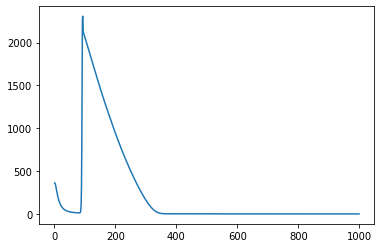

In [45]:
plt.plot(df3['$||\nabla_x J||$'][1:1000])

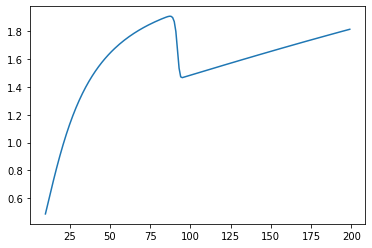

In [46]:
plt.plot(range(10,200), df3["beta"][10:200])

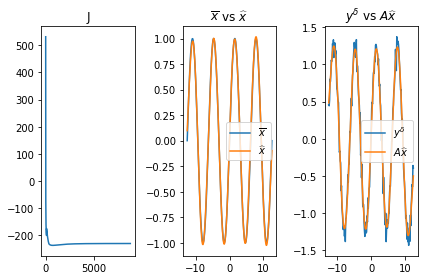

Lambda: 0.01813425437349123
Error: 0.11871795211476344
Obj val: -229.6188237647374


In [47]:
name = plot_path+'algo3'
plot_results(obj, t,A, x_bar, x_hat,alpha_hat, beta_hat, y_delta,name)

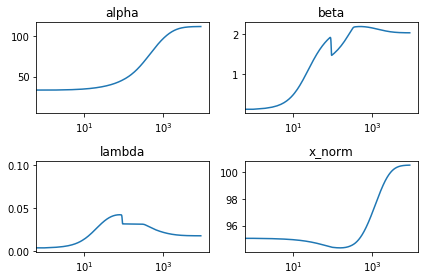

In [48]:
plot_estimates(df3,name)

In [49]:
df3.to_csv(csv_path+'algo_3')

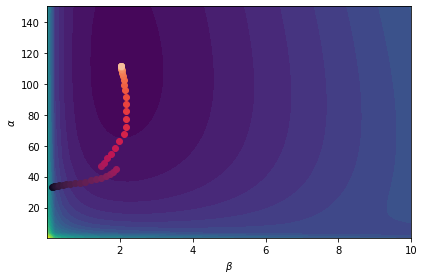

In [50]:
plot_contour(A,L, y_delta, df3, name ,ns=50)

### Method 4

In [51]:
sigma   = 1e-1
y_delta = y_bar + sigma*np.random.randn(n)
x_hat,alpha_hat,beta_hat,obj, df4 = Algorithm4(A,L, y_delta,niter=100000,tol=1e-3, print_res=True)
err = np.linalg.norm(x_bar-x_hat)**2
my_dict['Algo4']=[alpha_hat,beta_hat,beta_hat/alpha_hat,obj[-1],err,len(obj)-1]

Successful
Iterations: 3
Gradient: 0.0001035774151182303
0


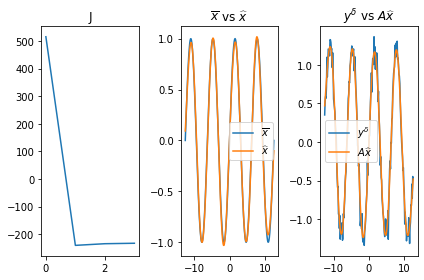

Lambda: 0.02154303635316205
Error: 0.2646313609393761
Obj val: -232.45480211110473


In [52]:
name = plot_path+'algo4'
plot_results(obj, t,A, x_bar, x_hat,alpha_hat, beta_hat, y_delta,name)

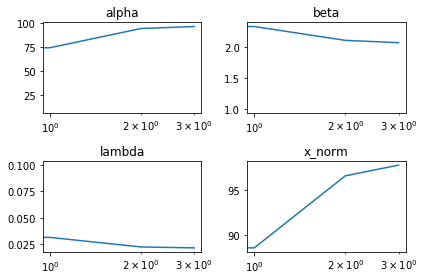

In [53]:
plot_estimates(df4,name)

In [54]:
df4.to_csv(csv_path+'algo_4')

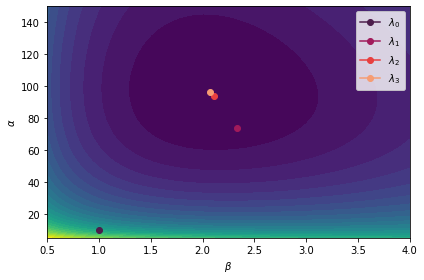

In [55]:
plot_contour(A,L, y_delta, df4, name , ranges=[5,150,0.5,4])

## Results 

In [56]:
algo_df = pd.DataFrame.from_dict(my_dict, orient='index')
algo_df.columns=['alpha','beta','lambda','obj','$||\overline{x}-\hat{x}||^2_2$','niter']
algo_df = algo_df.round(5)
algo_df.style.set_properties(subset=['$||\overline{x}-\hat{x}||^2_2$'], **{'width': '100px'})

,alpha,beta,lambda,obj,$||\overline{x}-\hat{x}||^2_2$,niter
Algo1,115.770200,2.095560,0.018100,-232.632610,0.211190,5
Algo2,97.463930,2.166160,0.022230,-237.016510,0.229790,8130
Algo3,111.516870,2.022280,0.018130,-229.618820,0.118720,8752
Algo4,96.076550,2.069780,0.021540,-232.454800,0.264630,3


In [57]:
#print(algo_df.to_latex())

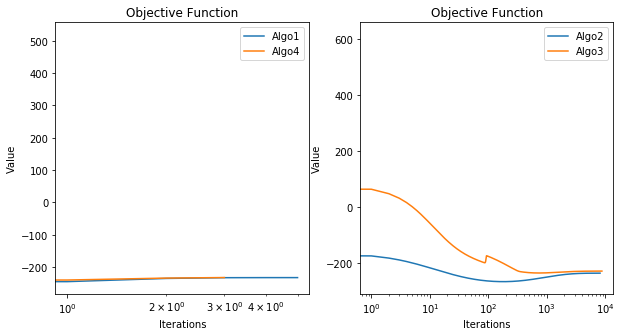

In [58]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(np.arange(len(df1['obj'].to_numpy())),df1['obj'].to_numpy(), label='Algo1')
ax[0].plot(np.arange(len(df4['obj'].to_numpy())),df4['obj'].to_numpy(), label='Algo4')
ax[0].set_xscale('log')
ax[0].set_title('Objective Function')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Value')
ax[0].legend()
ax[1].plot(np.arange(len(df2['obj'].to_numpy())),df2['obj'].to_numpy(),label='Algo2')
ax[1].plot(np.arange(len(df3['obj'].to_numpy())),df3['obj'].to_numpy(), label='Algo3')
ax[1].set_xscale('log')
ax[1].set_title('Objective Function')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Value')
ax[1].legend()

fig.savefig(plot_path+'obj_func.jpeg',dpi=300)
plt.show()

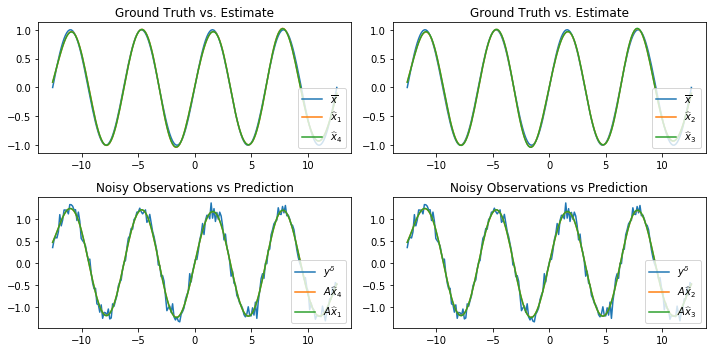

In [59]:
x_hat1 = np.linalg.solve(A.T@A + (df1['lambda'].to_numpy()[-1])*L.T@L, A.T@y_delta)
x_hat2 = np.linalg.solve(A.T@A + (df2['lambda'].to_numpy()[-1])*L.T@L, A.T@y_delta)
x_hat3 = np.linalg.solve(A.T@A + (df3['lambda'].to_numpy()[-1])*L.T@L, A.T@y_delta)
x_hat4 = np.linalg.solve(A.T@A + (df4['lambda'].to_numpy()[-1])*L.T@L, A.T@y_delta)


fig, ax = plt.subplots(2,2, figsize=(10,5))

ax[0,0].plot(t,x_bar,label='$\overline{x}$')
ax[0,0].plot(t,x_hat1,label='$\widehat{x}_1$')
ax[0,0].plot(t,x_hat4,label='$\widehat{x}_4$')
ax[0,0].set_title('Ground Truth vs. Estimate')

ax[0,1].plot(t,x_bar,label='$\overline{x}$')
ax[0,1].plot(t,x_hat2,label= '$\widehat{x}_2$')
ax[0,1].plot(t,x_hat3,label='$\widehat{x}_3$')
ax[0,1].set_title('Ground Truth vs. Estimate')

ax[0,0].legend(loc='lower right')
ax[0,1].legend(loc='lower right')

ax[1,0].plot(t,y_delta,label=r'$y^\delta$')
ax[1,0].plot(t,A@x_hat4,label=r'$A\widehat{x}_4$')
ax[1,0].plot(t,A@x_hat1,label=r'$A\widehat{x}_1$')
ax[1,0].set_title('Noisy Observations vs Prediction')

ax[1,1].plot(t,y_delta,label=r'$y^\delta$')
ax[1,1].plot(t,A@x_hat2,label=r'$A\widehat{x}_2$')
ax[1,1].plot(t,A@x_hat3,label=r'$A\widehat{x}_3$')
ax[1,1].set_title('Noisy Observations vs Prediction')

ax[1,0].legend(loc='lower right')
ax[1,1].legend(loc='lower right')

plt.tight_layout()
fig.savefig(plot_path+'results_summary.jpeg',dpi=300)

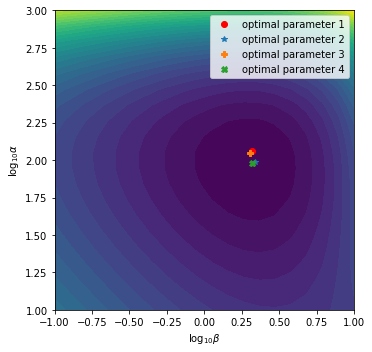

In [60]:
ns = 20

#theta = [alpha, beta]
obj = lambda theta : getObj(A,L,y_delta, theta[0], theta[1])


alphas = np.logspace(1,3,ns)
betas = np.logspace(-1,1,ns)


objs = np.zeros((ns,ns))

#solves for x_hat by using the previous alpha[i], beta[j]
for i in range(ns):
    for j in range(ns):
        objs[i,j] = obj([alphas[i],betas[j]])


fig, axs = plt.subplots(1,1,figsize=(10,5))

axs.contourf(np.log10(betas),np.log10(alphas),objs,levels=30)
axs.set_xlabel(r'$\log_{10} \beta$')
axs.set_ylabel(r'$\log_{10} \alpha$')

axs.plot(np.log10(df1['beta'].to_numpy()[-1]),np.log10(df1['alpha'].to_numpy()[-1]),'ro',label='optimal parameter 1')
axs.plot(np.log10(df2['beta'].to_numpy()[-1]),np.log10(df2['alpha'].to_numpy()[-1]),'*',label='optimal parameter 2')
axs.plot(np.log10(df3['beta'].to_numpy()[-1]),np.log10(df3['alpha'].to_numpy()[-1]),'P',label='optimal parameter 3' )
axs.plot(np.log10(df4['beta'].to_numpy()[-1]),np.log10(df4['alpha'].to_numpy()[-1]),'X',label='optimal parameter 4')

#axs.plot(np.log10(betas),np.log10(alpha_hat*(betas/beta_hat)),'w--')
axs.set_xlim(np.log10(betas[0]),np.log10(betas[-1]))
axs.set_ylim(np.log10(alphas[0]),np.log10(alphas[-1]))
axs.set_aspect(1)
axs.legend()


fig.set_figwidth(10)
fig.tight_layout()
fig.savefig(plot_path+'results_contour.jpeg',dpi=300)
